### imports

In [61]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import random

## First steps

In [62]:
env = gym.make('MountainCar-v0')

In [63]:
state_size = env.observation_space.shape[0]

In [64]:
action_size = env.action_space.n

### Defining the random agent

In [65]:
class RandomAgent :
    
    def __init__(self, state_size, action_size):
        self.action_size = action_size
        self.state_size = state_size
    
    def observe(self, state, action, next_state, reward):
        # For a random agent, we don't do anything with observations.
        pass

    def select_action(self, state):
        # Randomly choose an action from the action space.
        return env.action_space.sample()

    def update(self):
        # No update needed for a random agent.
        pass


In [66]:
random_agent = RandomAgent(state_size, action_size)

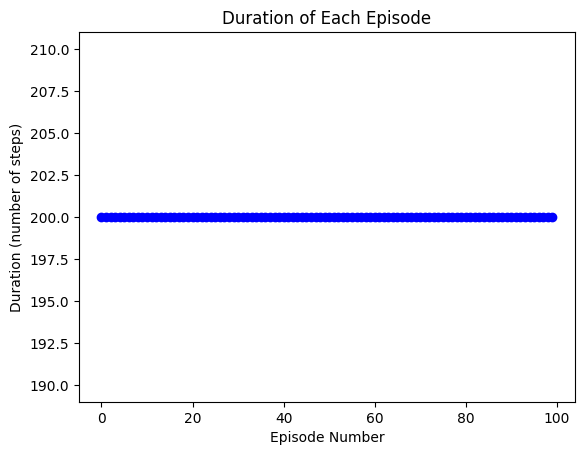

In [67]:
# Prepare to store episode durations
episode_durations = []

for e in range(100):
    done = False
    random_seed = random.randint(1, 100000)
    state, _ = env.reset(seed = random_seed)
    episode_reward = 0

    while not done:
        action = random_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        episode_reward += reward

        state = next_state
        done = terminated or truncated

    duration = -episode_reward
    episode_durations.append(duration)

plt.scatter(range(100), episode_durations, color='blue')
plt.title("Duration of Each Episode")
plt.xlabel("Episode Number")
plt.ylabel("Duration (number of steps)")
plt.show()    

#### Comments :

We can see given the scatter plot that the random agent performs very poorly, playing the maximum numbers of steps at each game and not solving the problem at all.

### Defining the deep network's structure

In [ ]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc1_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr= lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
     
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        
        return actions
    

### Defining the Agent


In [ ]:
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions, max_mem_size = 10000, eps_end = 0.05, eps_dec = 5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        
        self.Q_eval = DeepQNetwork(self.lr, n_actions = n_actions, input_dims = input_dims, fc1_dims = 64, fc2_dims = 64)
        
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype = np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype = np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype = np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype = np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype= np.bool_)
        
    def observe(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        
        self.mem_cntr +=1

    def choose_action(self,observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
            
        return action
    
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return
        
        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace = False)
        
        batch_index = np.arange(self.batch_size, dtype = np.int32)
        
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        
        action_batch = self.action_memory[batch]
        
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
        
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

### Main loop

In [ ]:
def plot_learning_curve(x, scores, epsilons, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    plt.savefig(filename)

In [ ]:
env = gym.make('MountainCar-v0')
agent = Agent(gamma = 0.99, epsilon = 0.9, batch_size = 64, n_actions = 3, eps_end = 0.05, input_dims = [2], lr = 0.003)
scores, eps_history = [], []
n_games = 1000

for i in range(n_games):
    score = 0
    done = False
    observation, _ = env.reset() # peut etre changer en observation, _ = 
    while not done : 
        action = agent.choose_action(observation)
        observation_, reward, terminated, truncated, _ = env.step(action)
        score += reward
        done = terminated or truncated
        agent.observe(observation, action, reward, observation_, done)
        agent.learn()
        obersation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)
    
    avg_score = np.mean(scores[-100:])
    
    print('episode ', i, 'score %.2f' % score, 'average score %.2f' % avg_score, 'epsilon %.2f' % agent.epsilon)
    
    #x = [i+1 for i in range(n_games)]
    #filename = 'mountain_car.png'
    #plot_learning_curve(x, scores, eps_history, filename)



#### Comments :

We see that even after a 1000 episodes of training the agent doesn't solve the task. This is due to the main challenge of the task which is the sparsity of the reward.